# Weed Classifier

**Author:** Marina Saito
***

## Overview and Business Problem

Gardeners and a great many homeowners have gardens.  And when they see something growing in the garden, they may want to identify the new plant they are observing to determine whether they should leave it be or if it’s a harmful or invasive species, to remove it from the garden.  A weed classifier can assist those, particularly novices, in identifying which plants to pull. 

Since the identification of a weed will ultimately result in it's removal, it is important not to misclassify perennials as weeds (i.e., to minimize false positives).  Therefore, I will focus on the precision score in evaluating my models.

## Data
### Compilation

The types of plants available depends on the geography.  Since I live in Chicago, I decided to focus on plants available in the midwest.

I gathered a list of best-performing perennials in the midwest from https://www.midwestgardentips.com/best-performing-perennials-1, and I gathered a list of common weeds in IL from https://www.preen.com/weeds (see [Create Plant List & Initial Scraping Notebook](../exploratory/datasets-create_lists_&_initial_scraping.ipynb)).

I included the weed photos that were available from the Preen website in my dataset (see [Create Plant List & Initial Scraping Notebook](../exploratory/datasets-create_lists_&_initial_scraping.ipynb)).  I also used three additional sources to compile the photos for my dataset:

1.  https://garden.org collects and categorizes photographs from its members.  The plants in some of these photos were in the background (e.g., the primary focus of the photo may have been a bee instead of the plant), so some of these photos includes misleading information.   (See [Create Plant List & Initial Scraping Notebook](../exploratory/datasets-create_lists_&_initial_scraping.ipynb).)
2.  The Missouri Botanical Gardens (https://www.missouribotanicalgarden.org) provides photos of various plants, but does not include any photos of weeds.  (See [Scrape Perennials Notebook](../exploratory/datasets-scrape_from_missouri_botanical_garden.ipynb).)  The Missouri Botanical Gardens referred to the University of Massachusetts Amherst for all weed photos.
3.  The University of Massachusetts Amherst (http://extension.umass.edu/landscape/weed-herbarium/) provides photos of various weeds in its Weed Herbarium.  (See [Scrape UMass Weeds Notebook](../exploratory/datasets-scrape_weeds_from_UMass.ipynb).)

I ultimately collected 2812 photos of perennials and 2990 photos of weeds.  I randomly selected 10% of both the perennials and the weeds to include in my test dataset (see [Split Test and Training Notebook](../exploratory/datasets-split_test_&_training.ipynb)).

In [1]:
# Standard Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

# Modeling Imports
from tensorflow.keras import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import (Dense, Flatten, Input, Dropout, 
                                     Add, BatchNormalization, Activation, 
                                     Conv2D, MaxPooling2D)

from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay, 
                             accuracy_score, precision_score)
from sklearn.utils import class_weight

# Lime Imports
%load_ext autoreload
%autoreload 2
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries

import sys
sys.path.append(os.path.join(os.pardir, os.pardir, 'src'))
import functions as fx

### Preparation

Because the training of convolutional neural networks improves with the amount of data used to train the model, I will use the following data augmentation techniques to artificially expand the size of the training data set:
- Rotate the images +/- 30 degrees
- Zoom in and out
- Shift left and right
- Shift up and down
- Horzontal split
- Adjust brightness

In [2]:
train_path = os.path.join(os.pardir, os.pardir, 'data', 'train')
test_path = os.path.join(os.pardir, os.pardir, 'data', 'test')

# Augment images in training dataset
# Rotate images +/- 30 degrees
# Zoom range between 70 and 130%
# Horizontally shift images by 20% of width
# Vertically shift images by 20% of height
# Allow horizontal flipping of images
# Darken and brighten the image by 50%
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 30, zoom_range = 0.3,
                                   width_shift_range = 0.2, height_shift_range = 0.2,
                                   horizontal_flip = True, brightness_range = [0.5, 1.5], 
                                   validation_split = 0.1)
val_datagen = ImageDataGenerator(rescale = 1./255, validation_split = 0.1)
train_generator = train_datagen.flow_from_directory(
    train_path, seed = 55, target_size = (256, 256), 
    batch_size = 64, class_mode = 'binary', 
    classes = ['perennials', 'weeds'], subset = 'training')
val_generator = val_datagen.flow_from_directory(
    train_path, seed = 55, target_size = (256, 256),
    batch_size = 64, class_mode = 'binary', 
    classes = ['perennials', 'weeds'], subset = 'validation')
test_generator = ImageDataGenerator(rescale = 1./255.) \
    .flow_from_directory(test_path, target_size = (256, 256), 
                         batch_size = 64, class_mode = 'binary', 
                         classes = ['perennials', 'weeds'])

Found 4698 images belonging to 2 classes.
Found 521 images belonging to 2 classes.
Found 580 images belonging to 2 classes.


### Visual Inspection

Below are multiple examples comparing perennials (left) with weeds (right):
- The perennials appear to be more colorful than the weeds
- The perennials also appear to have larger leaves with more texture than the weeds

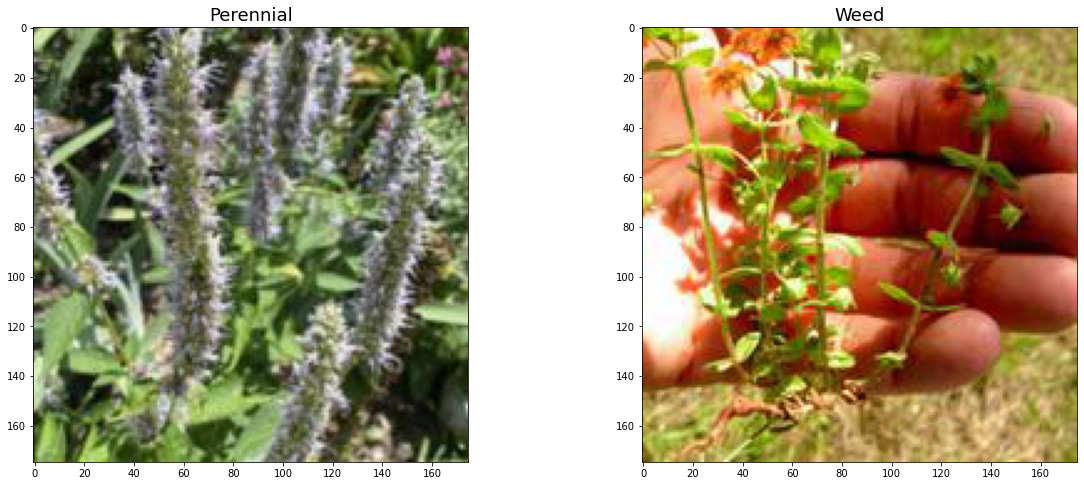

In [12]:
fx.compare_plants('0')

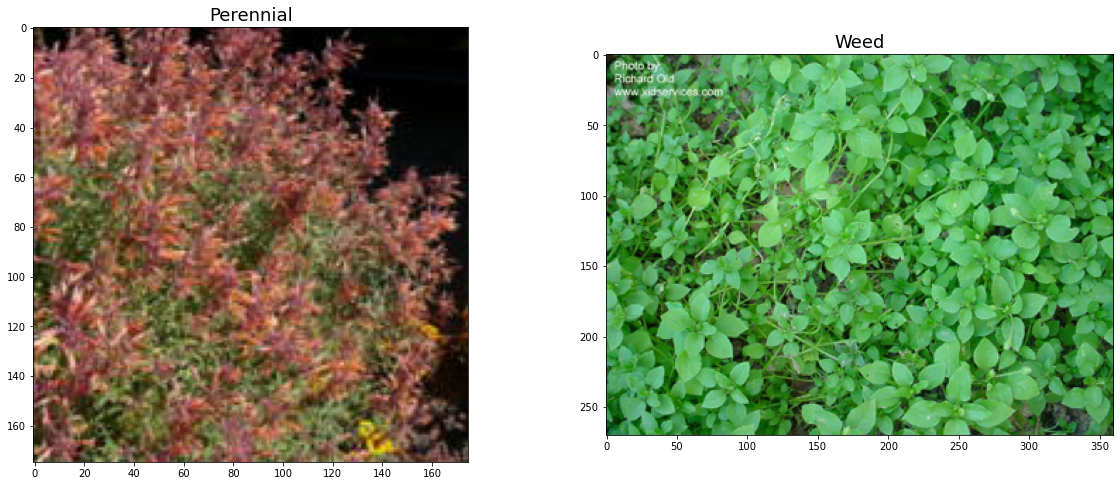

In [13]:
fx.compare_plants('1')

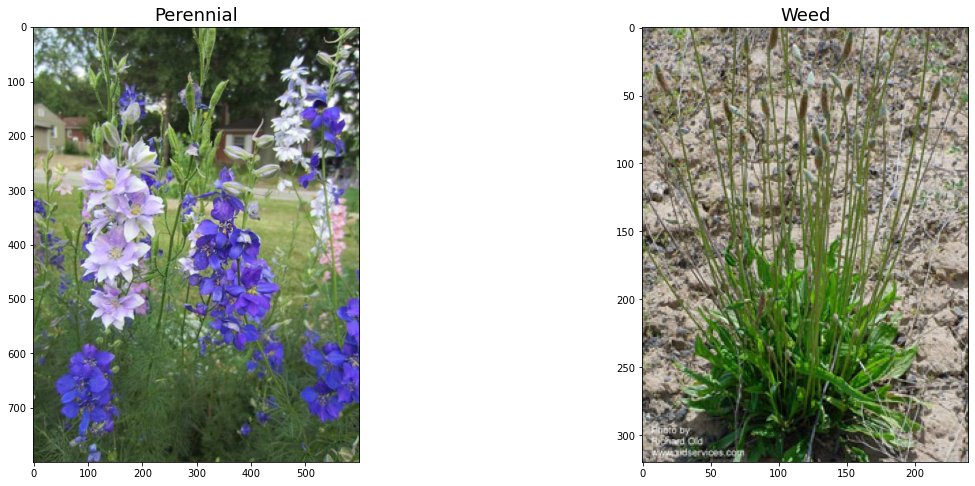

In [14]:
fx.compare_plants('2')

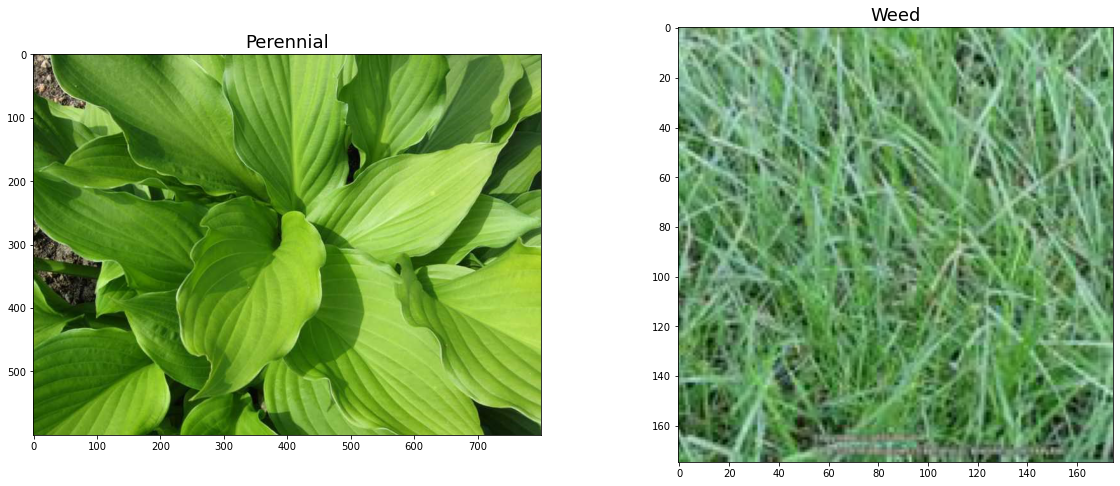

In [15]:
fx.compare_plants('3')

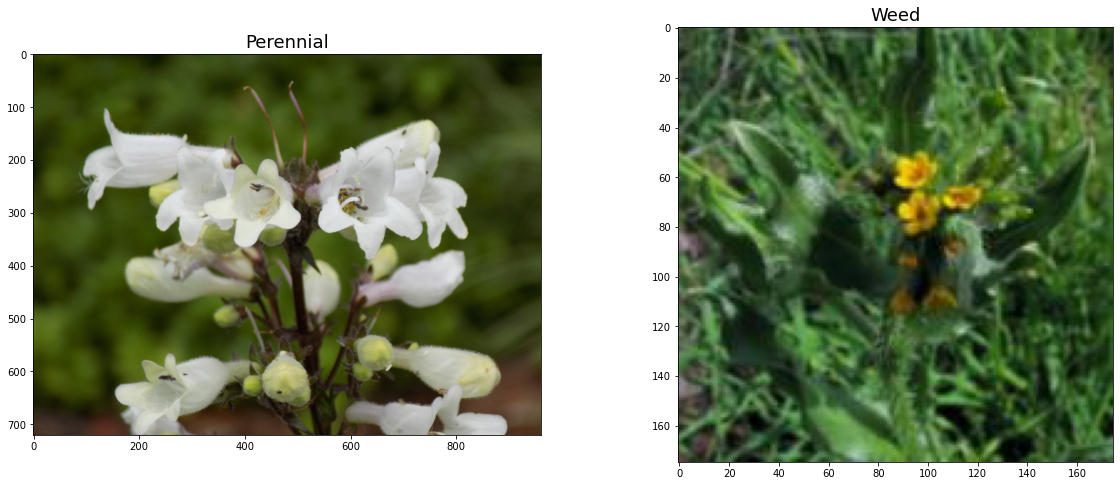

In [16]:
fx.compare_plants('4')

In [3]:
# Calculate weights to balance perennial and weed data in training set
class_weights = class_weight.compute_class_weight(
    class_weight = 'balanced', classes = np.unique(train_generator.classes), 
    y = train_generator.classes)
train_class_weights = dict(enumerate(class_weights))

# Stop training if training accuracy does not decrease in 5 epochs
early_stop_loss = EarlyStopping(monitor = 'accuracy', patience = 10, restore_best_weights = True)

## Methods
### Model Development
Initially I ran two very simple models: one baseline model with a single hidden layer, and one convolutional neural network with a single hidden layer.  To review the simple models, please review my [Simple Model notebook](../exploratory/simple_models.ipynb).

I then started with a model having two convolutional layers and three dense layers as a starting point for my models.  I tried adding an additional convolutional layer and/or dense layer.  I also tried adding L2 regularization throughout the model.  To review my modeling process, please review my [Build Models Notebook](../exploratory/build_models.ipynb).

I also tried various classic algorithms on the data to determine how well they performed on the dataset.  To review the analysis on the classic algorithms, please review my [Classic Architectures notebook](../exploratory/classic_architectures.ipynb).

Finally, I tried deeper neural networks having three convolutional layers and five dense layers.  I tried using a dropout layer with the model as well as an L2 regularization layer.  I found that the deeper neural network model with the dropout layer performed better best.  To review the analysis using the deeper neural networks, please review my [Deeper Neural Network notebook](../exploratory/deeper_models.ipynb) and my [Deeper L2 notebook](../exploratory/deeper_l2_models.ipynb) (which runs a second L2 regularization in the dense layer).

### Final Model
- Three convolutional layers
- Five dense layers with a 0.2 dropout layer after the first dense layer

In [4]:
def final(image):
    layers = [
        Input(image.shape),
        Conv2D(16, (5, 5), activation = 'relu'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Conv2D(32, (5, 5), activation = 'relu'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Conv2D(64, (5, 5), activation = 'relu'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Flatten(),
        Dense(512, activation = 'relu'),
        Dropout(0.2),
        Dense(256, activation = 'relu'),
        Dense(128, activation = 'relu'),
        Dense(64, activation = 'relu'),
        Dense(1, activation = 'sigmoid')
    ]
    model = Sequential(layers)
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy', 'Precision'])
    return model

In [5]:
final_model = final(train_generator[0][0][0])
final_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 252, 252, 16)      1216      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 126, 126, 16)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 16)      64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 122, 122, 32)      12832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 61, 61, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 57, 57, 64)        5

In [6]:
final_result = final_model.fit(train_generator, epochs = 75, validation_data=val_generator,
                               class_weight = train_class_weights, callbacks = [early_stop_loss])

Epoch 1/75
74/74 [==============================] - 132s 2s/step - loss: 1.0598 - accuracy: 0.6337 - precision: 0.6423 - val_loss: 0.7566 - val_accuracy: 0.5317 - val_precision: 0.6200
Epoch 2/75
74/74 [==============================] - 130s 2s/step - loss: 0.7109 - accuracy: 0.6762 - precision: 0.6849 - val_loss: 0.8265 - val_accuracy: 0.5163 - val_precision: 0.5154
Epoch 3/75
74/74 [==============================] - 131s 2s/step - loss: 0.5625 - accuracy: 0.7258 - precision: 0.7235 - val_loss: 1.3343 - val_accuracy: 0.5125 - val_precision: 0.5135
Epoch 4/75
74/74 [==============================] - 129s 2s/step - loss: 0.5546 - accuracy: 0.7375 - precision: 0.7372 - val_loss: 0.9892 - val_accuracy: 0.5202 - val_precision: 0.5177
Epoch 5/75
74/74 [==============================] - 129s 2s/step - loss: 0.5299 - accuracy: 0.7567 - precision: 0.7548 - val_loss: 0.6932 - val_accuracy: 0.5835 - val_precision: 0.5539
Epoch 6/75
74/74 [==============================] - 129s 2s/step - loss: 0.

## Results
- As depicted below
    - the validation loss did not decrease with additional epochs.  In other words, the error of the output layer during backpropagation did not decrease with additional training.
    - the validation accuracy appears to fluctuate around 65%
    - the validation precision does not increase with additional training

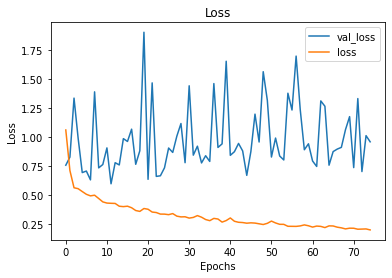

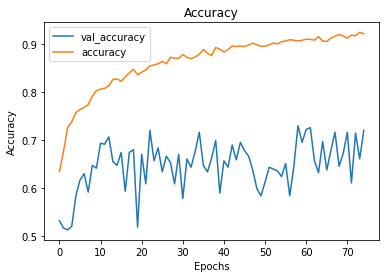

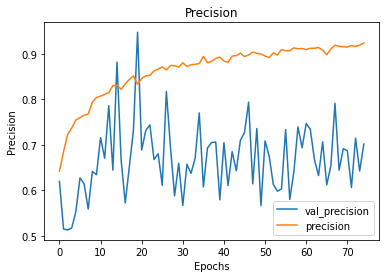

In [7]:
fx.visualize_training_results(final_result, 'final')

### Results on Test Data
- The metrics below indicate 52% accuracy and a 54% precision score on the test data

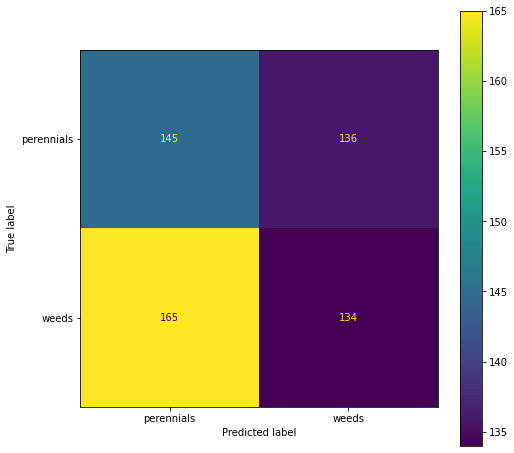

In [8]:
fx.create_confusion_matrix(final_model, test_generator, 'final')

In [9]:
fx.get_metrics(final_model, test_generator)

Accuracy: 0.5189655172413793
Precision: 0.5370370370370371


### Lime
- I implemented a package called [lime](https://github.com/marcotcr/lime) (local interpretable model-agnostic explanations) to illustrate the areas on the plants that the model focused on to classify the plant as a perennial or as a weed
- Lime highlights in the images below pros in green and cons in red
- Unfortunately, the model does focus on the plants to classify whether the plant is a perennial or a weed

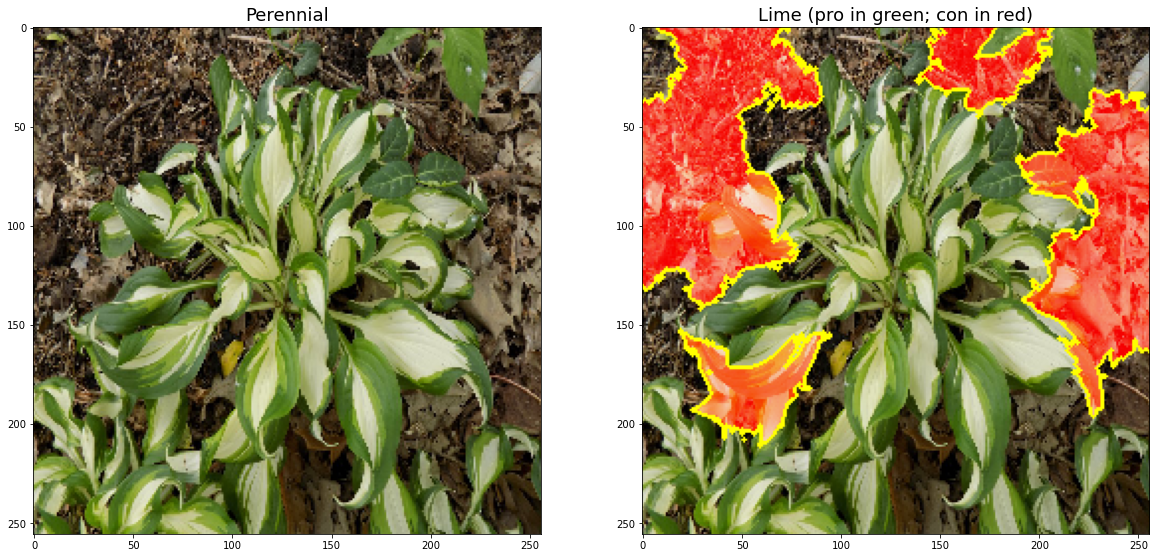

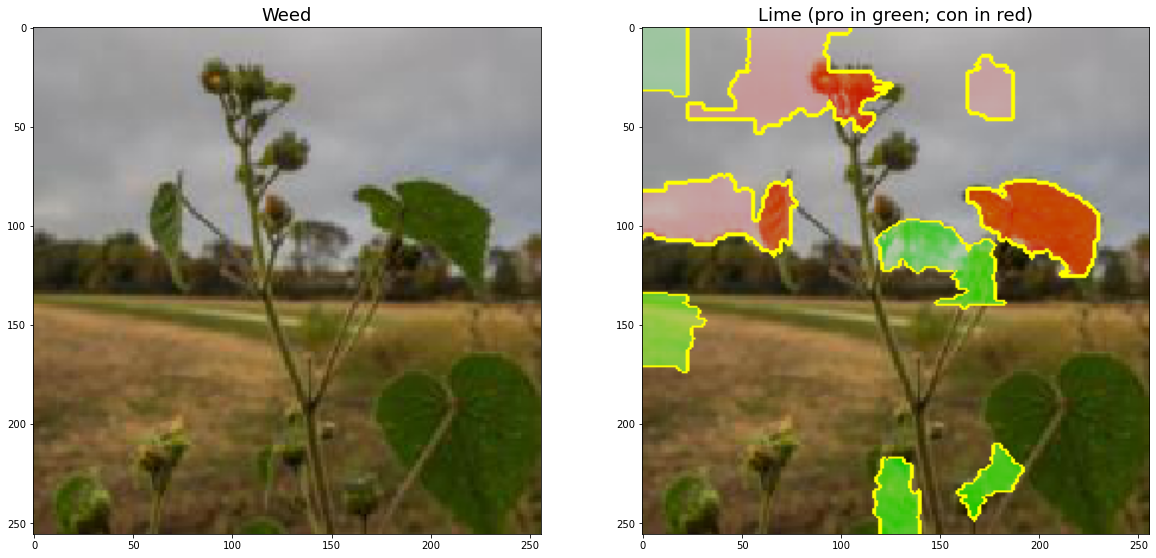

In [10]:
fx.display_lime(final_model, test_generator, 'final')

### Transfer Learning Evaluation
I implemented a pretrained VGG model to determine how well a pretrained model performs on my dataset
- the validation loss did not decrease with additional epochs.
- the validation accuracy appears to fluctuate around 73%
<img src = "../../reports/images/vgg_loss_plot.png"><img src = "../../reports/images/vgg_acc_plot.png">

The pretrained model performs better on the validation data than my model by approximately 8%

#### Results on Test Data
- The metrics below indicate 50% accuracy and a 52% precision score on the test data
<img src = "../../reports/images/vgg_confusion_matrix.png">

#### Lime
- The pretrained model also does not focus solely on the plants to classify whether the plant is a perennial or a weed
<img src = "../../reports/images/vgg_lime_peren.png">
<img src = "../../reports/images/vgg_lime_weed.png">

## Save final model

In [34]:
final_model.save(os.path.join(os.pardir, os.pardir, 'final_model', 'final_model.h5'))

## Conclusion
- I created a convolutional neural network model that classifies plants as either perennials or weeds.
- The model is not performing very well
    - The accuracy of the model on the test dataset is 52% with a precision of 54% 
    - The model is not classifying the images by focusing solely on the plants
- The pretrained VGG-16 model also did not perform well on the dataset
    - Though the accuracy on the validation dataset was better, the performance on the test dataset was no better than my model
    - The accuracy of the pretrained model on the test dataset is 50% with a precision of 52% 
    - The model is not classifying the images by focusing solely on the plants

## Next Steps
- Try other pretrained models to determine whether there is a better match to the dataset
- Continue adjusting model parameters to improve model classification
- Find new sources of data
- Try implementing image segmentation to see if it's possible to develop a model that could isolate the relevant parts of the image